## Generic Object Decoding parcellation

The generic object decoding approach ([Horikawa & al](https://www.nature.com/articles/ncomms15037) ) enabled decoding of arbitrary object categories including those not used in model training. Here I make use of the Imagefeatures and fMRI data used in this paper for encoding pusposes.

In [0]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline 

In [0]:
!pip install nilearn

### Loading the Feature Vector. 


In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import matlab
mat = matlab.engine.start_matlab()
f = mat.load("ImageFeatures.mat", nargout=1)

Now we load the fMRI data and perform a parcellation.  

In [0]:
from nilearn import plotting
from nilearn import image
smooth_anat_img = image.smooth_img(path, fwhm=3)

path = './Subject2_T1wAligned (1).nii'
plotting.plot_img(path)
print(smooth_anat_img)

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

We can have a look at the average over time of all images. This will show the structure of the brain of the particular subject

In [0]:
np.save('fmri_data', fmri_data)

In [0]:
from nilearn.image import mean_img
from nilearn.plotting import plot_anat
fmri_mean = mean_img(smooth_anat_img)

plot_anat(fmri_mean)
plt.show()
plt.savefig('mean_img.png')

In [0]:
from nilearn.regions import Parcellations
myparc = Parcellations(method='ward',n_parcels=300,detrend=True,standardize=True)
fmri_data = myparc.fit_transform(smooth_anat_img)

In [0]:
cd Colab\ Notebooks

/gdrive/My Drive/Colab Notebooks


In [0]:
ls

 adc.json             'Subject2_T1wAligned (1).nii'
 books_read.png       ' Subject2_T1wAligned.nii'
' ImageFeatures.mat'   Subject2_T1wAligned.nii
 ImageFeatures.mat     Subject2_T1wAligned.nii.gz
 sample_data/


Visualize the parcellation

In [0]:
ward_labels_img = myparc.labels_img_

# Now, ward_labels_img are Nifti1Image object, it can be saved to file
# with the following code:
#ward_labels_img.to_filename('ward_parcellation.nii.gz')

from nilearn import plotting
from nilearn.image import mean_img, index_img

first_plot = plotting.plot_roi(ward_labels_img, bg_img=fmri_mean,title="Ward parcellation",
                               display_mode='xz')

# Grab cut coordinates from this plot to use as a common for all plots
cut_coords = first_plot.cut_coords
plt.show()
plt.savefig('Ward parcellation')

Some points in at the beginning should be droped since the scanner started before the video in the experiment

In [0]:
fmri_ready = fmri_data[17:-(fmri_data.shape[0]-17)]

##building the encoding models

In [0]:

middle = int(fv.shape[0]/2)
y_train = fmri_ready[:middle] 
y_test = fmri_ready[middle:]
X_train = (fv[:middle])
X_test = (fv[middle:])

And finally we can estimate our model of brain activity. We use Ridge Regression here, which is a linear regression with a penalty on the L2 norm. More on Ridge [here](http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression). 

We train Ridge using the fit method on the training set, and we predict brain activity on the test set. 

In [0]:
from sklearn.linear_model import Ridge

estimator = Ridge(alpha=25000) # Alpha value has been explored before

estimator.fit(X_train,y_train)
predictions = estimator.predict(X_test)

Finally, we measure the quality of prediction using R2 score, which estimates how much the predictions and the true values are linearly related. 
We eliminate the negative scores which correspond to failed predictions. 

The R2 score is estimated for each voxel in the brain. 

In [0]:
from sklearn.metrics import r2_score
scores = r2_score(y_test, predictions, multioutput='raw_values')
scores[scores < 0] = 0

We can project the R2 map on the brain (using the inverse_transform method of the masker) to see which voxels are the most predictive. 

In [0]:
scores_img = myparc.inverse_transform(scores.reshape(1,-1))


/home/nfarrugi/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


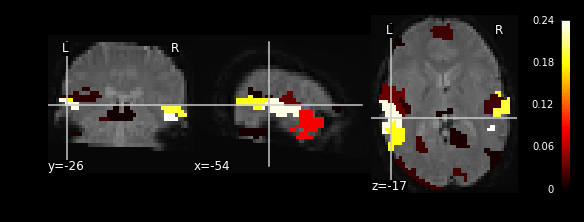

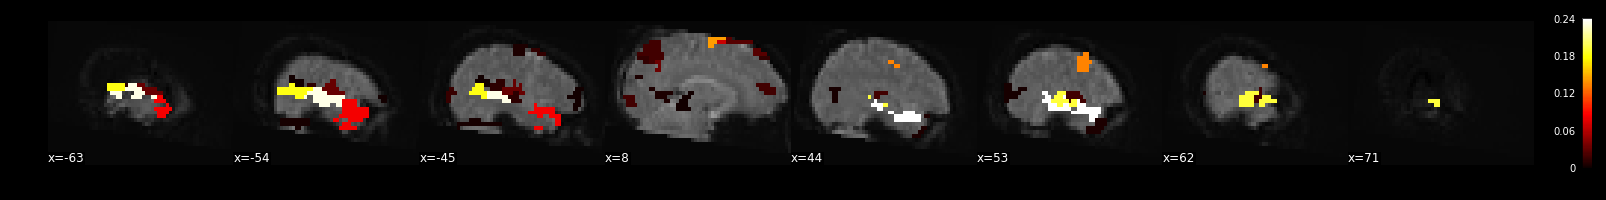

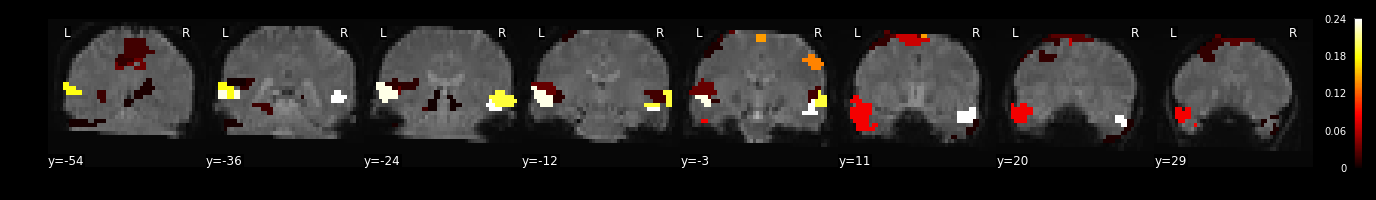

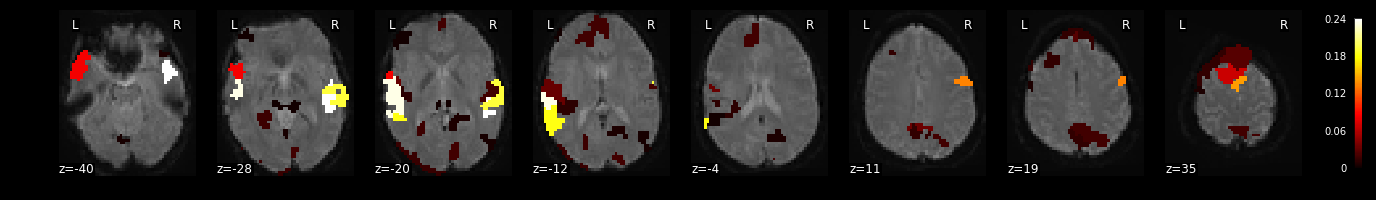

In [0]:
from nilearn.plotting import plot_stat_map
plot_stat_map(scores_img,bg_img=fmri_mean)
plt.show()
plot_stat_map(scores_img,bg_img=fmri_mean,cut_coords=8,display_mode='x')
plt.show()
plot_stat_map(scores_img,bg_img=fmri_mean,cut_coords=8,display_mode='y')
plt.show()
plot_stat_map(scores_img,bg_img=fmri_mean,cut_coords=8,display_mode='z')
plt.show()

In [0]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penality = 'l2', C= 1/25000, random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_train,y_train)
predictions = estimator.predict(X_test)

clf.predict_proba(X[:2, :]) 


clf.score(X, y)
